<a href="https://colab.research.google.com/github/brash99/phys441/blob/master/JupyterNotebooks/TravelingWaveConvection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Diffusion and Convection in 1D

### Burger's Equation

\begin{equation}
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} = 0
\end{equation}

where $\nu$ is the viscosity.  As in the previous examples, we use the forward difference for the time derivative, the backward difference for the spatial first derivative, and the central difference for the spatial second derivative.

\begin{equation}
\frac{u_i^{n+1} -  u_i^n}{\Delta t} + u^n_i \left( \frac{u^n_{i} - u^n_{i-1}}{\Delta x} \right) - \nu \left( \frac{u^n_{i+1} - 2 u^n_i + u^n_{i-1}}{\Delta x^2} \right) = 0
\end{equation}

\begin{equation}
u_i^{n+1} =  u_i^n - \frac{\Delta t}{\Delta x} u_i^n \left( u^n_{i} - u^n_{i-1} \right) + \frac{\nu \Delta t}{\Delta x^2} \left( u^n_{i+1} - 2 u^n_i + u^n_{i-1} \right)
\end{equation}

In [1]:
# Remember: comments in python are denoted by the pound sign
import numpy                            #here we load numpy
from matplotlib import pyplot as plt     #here we load matplotlib
import time, sys                         #and load some utilities

import sympy
from sympy import init_printing
from sympy.utilities.lambdify import lambdify
    
from numba import njit, prange

In [2]:
#this makes matplotlib plots appear in the notebook (instead of a separate window)
%matplotlib inline                  

In [3]:
@njit(fastmath=True, cache=True)
def loopit(u, nt, nx, dt, dx, viscosity):
    for n in range(nt):  #loop for values of n from 0 to nt, so it will run nt times
        un = u.copy() ##copy the existing values of u into un
        for i in range(1, nx-1):
            u[i] = un[i] - dt/dx*un[i]*(un[i]-un[i-1]) + viscosity * dt / dx**2 * (un[i+1] - 2.0*un[i] + un[i-1])
        u[0] = un[0] - dt/dx*un[0]*(un[0]-un[-2]) + viscosity * dt / dx**2 * (un[1] - 2.0*un[0] + un[-2])
        u[-1] = un[0]       

In [4]:
def loopit_fast(u, nt, nx, dt, dx, viscosity):
    for n in range(nt):  #loop for values of n from 0 to nt, so it will run nt times
        un = u.copy() ##copy the existing values of u into un

        u[1:nx-1] = un[1:nx-1] - dt/dx*un[1:nx-1]*(un[1:nx-1]-un[:nx-2]) + viscosity * dt / dx**2 * (un[2:nx] - 2.0*un[1:nx-1] + un[:nx-2])

        u[0] = un[0] - dt/dx*un[0]*(un[0]-un[-2]) + viscosity * dt / dx**2 * (un[1] - 2.0*un[0] + un[-2])
        u[-1] = un[0]       

In [10]:
def burger_1d(nt = 427, pulseShapeChoice = 3):

    # We define the x-axis to start at x=0.0m and end at x=2*Pi.
    # 
    # We specify the number of steps in x (nx), and the number
    # of steps in t (nt), and calculate dx and dt based on these choices.

    xrange = 2*numpy.pi
    trange = 0.5
    nx = 401
    dx = xrange / (nx-1)
    dt = trange / (nt-1)

    viscosity = 0.07
    
    # Analytical Solution
    
    #init_printing(use_latex=True)

    xa, nu, t = sympy.symbols('xa nu t')
    phi = (sympy.exp(-(xa - 4 * t)**2 / (4 * nu * (t + 1))) +
           sympy.exp(-(xa - 4 * t - 2 * sympy.pi)**2 / (4 * nu * (t + 1))))

    phiprime = phi.diff(xa)


    u = -2 * nu * (phiprime / phi) + 4
    ufunc = lambdify((t, xa, nu), u)
    #print(ufunc(1, 4, 3))

    xb = numpy.linspace(0, xrange, nx)
    u_analytical = numpy.asarray([ufunc(nt*dt, xa, viscosity) for xa in xb])
    
    # Set the wavefunction equal to all ones, initially

    x = numpy.linspace(0,xrange,nx)

    if (pulseShapeChoice == 1):
      # Test Case 1: Square Pulse
      u = numpy.ones(nx)      #numpy function ones()
      u[int((numpy.pi-0.1)/dx):int((numpy.pi+0.1)/dx + 1)] = 2  #setting u = 2 between 0.5 and 1
    else: 
        if (pulseShapeChoice == 2):
            # Test Case 2:  Gaussian Pulse
            u = numpy.ones(nx)      #numpy function ones()
            mu = numpy.pi
            sigma = 0.1
            for i in range(len(u)):
                u[i]=u[i]+numpy.exp(-1.0*(x[i]-mu)**2/sigma**2)
        else:
            u = numpy.zeros(nx)      #numpy function ones()
            for i in range(len(u)):
                t1 = numpy.exp(-1.0*x[i]**2/(4.0*viscosity))
                t2 = numpy.exp(-1.0*(x[i]-2.0*numpy.pi)**2/(4.0*viscosity))
                u[i] = (x[i]*t1+(x[i]-2.0*numpy.pi)*t2)/(t1+t2)+4.0
                
    plt.plot(x, u, '.-')
    #print ("Integral = ",u.sum()-4.0*len(x))
    
    plt.plot(x, u, '.-')

    loopit(u, nt, nx, dt, dx, viscosity)
    
    plt.plot(x, u, '.-')
    #print ("Integral = ",u.sum()-4.0*len(x))
    if (pulseShapeChoice == 3):
        plt.plot(x, u_analytical, label='Analytical')

18.8 ms ± 21.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


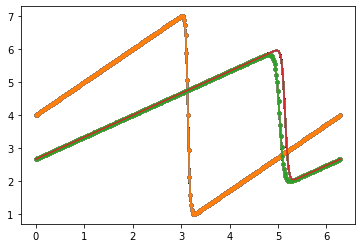

In [11]:
%%timeit
burger_1d(500,3)

In [12]:
def burger_1d_fast(nt = 427, pulseShapeChoice = 3):

    # We define the x-axis to start at x=0.0m and end at x=2*Pi.
    # 
    # We specify the number of steps in x (nx), and the number
    # of steps in t (nt), and calculate dx and dt based on these choices.

    xrange = 2*numpy.pi
    trange = 0.5
    nx = 401
    dx = xrange / (nx-1)
    dt = trange / (nt-1)

    viscosity = 0.07
    
    # Analytical Solution
    
    #init_printing(use_latex=True)

    xa, nu, t = sympy.symbols('xa nu t')
    phi = (sympy.exp(-(xa - 4 * t)**2 / (4 * nu * (t + 1))) +
           sympy.exp(-(xa - 4 * t - 2 * sympy.pi)**2 / (4 * nu * (t + 1))))

    phiprime = phi.diff(xa)


    u = -2 * nu * (phiprime / phi) + 4
    ufunc = lambdify((t, xa, nu), u)
    #print(ufunc(1, 4, 3))

    xb = numpy.linspace(0, xrange, nx)
    u_analytical = numpy.asarray([ufunc(nt*dt, xa, viscosity) for xa in xb])
    
    # Set the wavefunction equal to all ones, initially

    x = numpy.linspace(0,xrange,nx)

    if (pulseShapeChoice == 1):
      # Test Case 1: Square Pulse
      u = numpy.ones(nx)      #numpy function ones()
      u[int((numpy.pi-0.1)/dx):int((numpy.pi+0.1)/dx + 1)] = 2  #setting u = 2 between 0.5 and 1
    else: 
        if (pulseShapeChoice == 2):
            # Test Case 2:  Gaussian Pulse
            u = numpy.ones(nx)      #numpy function ones()
            mu = numpy.pi
            sigma = 0.1
            for i in range(len(u)):
                u[i]=u[i]+numpy.exp(-1.0*(x[i]-mu)**2/sigma**2)
        else:
            u = numpy.zeros(nx)      #numpy function ones()
            for i in range(len(u)):
                t1 = numpy.exp(-1.0*x[i]**2/(4.0*viscosity))
                t2 = numpy.exp(-1.0*(x[i]-2.0*numpy.pi)**2/(4.0*viscosity))
                u[i] = (x[i]*t1+(x[i]-2.0*numpy.pi)*t2)/(t1+t2)+4.0
                
    plt.plot(x, u, '.-')
    #print ("Integral = ",u.sum()-4.0*len(x))
    
    plt.plot(x, u, '.-')

    loopit_fast(u, nt, nx, dt, dx, viscosity)
    
    plt.plot(x, u, '.-')
    #print ("Integral = ",u.sum()-4.0*len(x))
    if (pulseShapeChoice == 3):
        plt.plot(x, u_analytical, label='Analytical')

23.7 ms ± 27.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


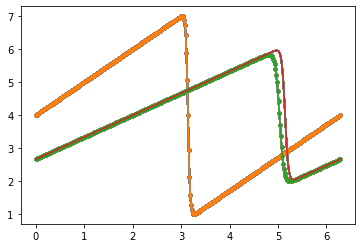

In [13]:
%%timeit
burger_1d_fast(500,3)